# CS236 Final Project

# Do Generative Transformers Read Like Bidirectional Models (BERT)?

Last edit: 12-7-2021

By: Amil Merchant

This notebook is used to re-produce the main results for the paper; it includes additional analysis that did not make it to the core body of the paper but I (Amil) find intersting.

Notes:
- This notebook is written and tested for GPU runtime on colab. An equivalent setup for Jupyter notebook and local evaluation could be created based on these schemas.

## Install necessary libraries and prepare plotting utilities

In [ ]:
# Assuming we are on a colab instance, install Hugging Face libraries
# Please restart after installing the necessary libraries
!pip install --upgrade matplotlib
!pip install transformers
!pip install datasets

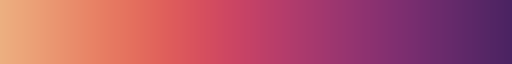

In [ ]:
# Prepare plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.color_palette("flare", as_cmap=True)

In [ ]:
import numpy as np
import torch
# Use AutoModel and AutoTokenizer to load default parameters for GPT-2 and BERT
from transformers import AutoTokenizer, AutoModel

import random
# TQDM provides a useful progress bar for long evaluation runs
import tqdm

In [ ]:
# Download the SQUAD dataset for a set of examples of generic web text
from datasets import load_dataset
squad = load_dataset('squad')

Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

## Utilities to extract representations

In [ ]:
# Extract hidden representations
# https://discuss.huggingface.co/t/generate-raw-word-embeddings-using-transformer-models-like-bert-for-downstream-process/2958/2
# Modified to provide layer representations instead of mixing or averaging

def get_hidden_states(encoded, token_ids_word, model, layers):
     # No gradients required, only need output representations
     with torch.no_grad():
         output = model(**encoded)
 
     # Extract and process representations
     states = output.hidden_states
     output = torch.stack(states).squeeze()
     word_tokens_output = output[:, token_ids_word]
     return word_tokens_output.mean(dim=1).mean(dim=1)
     
def get_word_vector(sent, idx, tokenizer, model, layers=[], device="cpu"):
     encoded = tokenizer.encode_plus(sent, return_tensors="pt").to(device)
     token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
     return get_hidden_states(encoded, token_ids_word, model, layers)

In [ ]:
# Test the tokenizers and downloaded models
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

sent = "Machine learning is cool ." 

def get_word_idx(sent, word):
  return sent.split(" ").index(word)
  
idx = sent.split(" ").index("cool")
print(f"Index of the word cool: {idx}")
print(f"Full sentence: {sent}")

layers = None
word_embedding = get_word_vector(sent, idx, tokenizer, model, layers)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Index of the word cool: 3
Full sentence: Machine learning is cool .


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  del sys.path[0]


## Extract representations for BERT and GPT-2

In [ ]:
# Number of input examples
n = 500

In [ ]:
# Load both tokenizers and models
# As BERT and GPT-2 are relatively small, both can be loaded into memory
# at the same time to ensure that the same input examples are seen by
# both models (for RSA purposes).

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert_model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)
gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt_model = AutoModel.from_pretrained("gpt2", output_hidden_states=True)

# Place model on GPU if available
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if device != "cpu":
  bert_model = bert_model.to(device)
  gpt_model = gpt_model.to(device)

# Gather embeddings
bert_embeddings = []
gpt_embeddings = []

# Examples are from SQUAD
num_data = squad['validation'].num_rows

for index in tqdm.tqdm(range(n)):
  data_index = random.randint(0, num_data - 1)
  sentence = squad['validation'][data_index]['context']
  sentence_split = sentence.split(' ')[:128]
  num_words = len(sentence_split)

  random_index = 10 # Psuedo-random index, set for consistent results
  word_indices = get_word_idx(sentence, sentence_split[random_index])

  bert_word_embedding = get_word_vector(' '.join(sentence_split), word_indices, bert_tokenizer, bert_model, layers=range(13), device=device)
  gpt_word_embedding = get_word_vector(' '.join(sentence_split), word_indices, gpt_tokenizer, gpt_model, layers=range(13), device=device)
  
  # Return embeddings to CPU for analysis
  if device != "cpu":
    bert_word_embedding = bert_word_embedding.detach()
    gpt_word_embedding = gpt_word_embedding.detach()

  bert_embeddings.append(bert_word_embedding)
  gpt_embeddings.append(gpt_word_embedding)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 500/500 [00:09<00:00, 51.91it/s]


In [ ]:
# Aggregate sets of embeddings
bert_embeddings = torch.stack(bert_embeddings, dim=1)
gpt_embeddings = torch.stack(gpt_embeddings, dim=1)

## Utilities for computing Representational Similarity Analysis

In [ ]:
# Gather indices for the upper triangular of the matrices
upper_triangular = []
count = 0
for i in range(n):
  for j in range(n):
    if i <= j:
      upper_triangular.append(count)
    count += 1

print(len(upper_triangular))

125250


In [ ]:
def cosine_similarity(vectors):
  vectors /= torch.norm(vectors, p=2, dim=-1, keepdim=True)
  cosine = torch.einsum('ijk,ilk->ijl', vectors, vectors)
  return cosine

def normalize(all_pairwise):
  all_pairwise_corrected = all_pairwise - all_pairwise.mean(1, keepdim=True)
  norms = torch.norm(all_pairwise_corrected, p=2, dim=-1, keepdim=True)
  all_pairwise_scaled = all_pairwise_corrected / norms
  return all_pairwise_scaled

def extract_upper(all_pairwise_matrices):
  layers = all_pairwise_matrices.shape[0]
  all_pairwise_flattened = all_pairwise_matrices.reshape([layers, -1])
  all_pairwise_upper = all_pairwise_flattened[:, upper_triangular]
  return all_pairwise_upper

def rsa(all_representations, compared_representations=None):
  all_pairwise_matrices = cosine_similarity(all_representations)
  all_pairwise_upper = extract_upper(all_pairwise_matrices)
  all_pairwise_scaled = normalize(all_pairwise_upper)
  
  if compared_representations is not None:
    compared_pairwise_matrices = cosine_similarity(compared_representations)
    compared_pairwise_upper = extract_upper(compared_pairwise_matrices)
    compared_pairwise_scaled = normalize(compared_pairwise_upper)
    rsa_matrix = torch.einsum('ij,kj->ik', all_pairwise_scaled, compared_pairwise_scaled)
    return rsa_matrix

  rsa_matrix = torch.einsum('ij,kj->ik', all_pairwise_scaled, all_pairwise_scaled)
  return rsa_matrix                                        

## Plot Results from Similarity Analysis

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


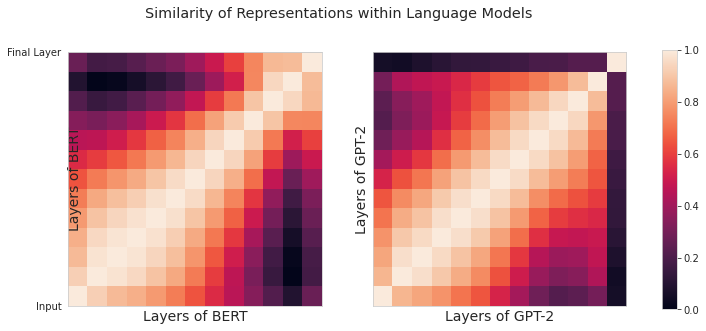

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rsa(bert_embeddings).cpu().numpy(), vmin=0)
plt.ylim([-0.5, 12.5])
plt.xticks([])
plt.yticks([-0.5, 12.5], ['Input', 'Final Layer'])
plt.xlabel('Layers of BERT', fontdict={'size'   : 14})
plt.ylabel('Layers of BERT', fontdict={'size'   : 14}, labelpad=-75)

plt.subplot(1, 2, 2)
im2 = plt.imshow(rsa(gpt_embeddings).cpu().numpy(), vmin=0)
plt.ylim([-0.5, 12.5])
plt.xticks([])
plt.yticks([])
plt.xlabel('Layers of GPT-2', fontdict={'size'   : 14})
plt.ylabel('Layers of GPT-2', fontdict={'size'   : 14})

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.14, 0.02, 0.72])
fig.colorbar(im2, cax=cbar_ax, aspect=50)

plt.suptitle('Similarity of Representations within Language Models', fontsize='x-large')
plt.show()

In [ ]:
font = {'size'   : 14}

matplotlib.rc('font', **font)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  """


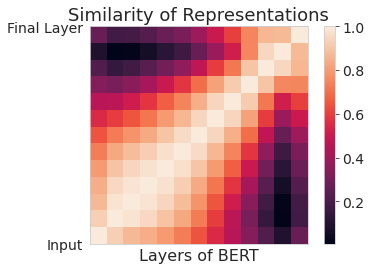

In [ ]:
plt.imshow(rsa(bert_embeddings).cpu().numpy())
plt.ylim([-0.5, 12.5])
plt.xticks([])
plt.yticks([-0.5, 12.5], ['Input', 'Final Layer'])
plt.colorbar()
plt.title('Similarity of Representations', fontdict={'size'   : 18})
plt.xlabel('Layers of BERT', fontdict={'size'   : 16})
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  """


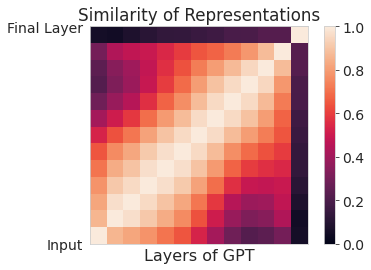

In [ ]:
plt.imshow(rsa(gpt_embeddings).cpu().numpy(), vmin=0)
plt.ylim([-0.5, 12.5])
plt.xticks([])
plt.yticks([-0.5, 12.5], ['Input', 'Final Layer'])
plt.colorbar()
plt.title('Similarity of Representations')
plt.xlabel('Layers of GPT', fontdict={'size'   : 16})
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


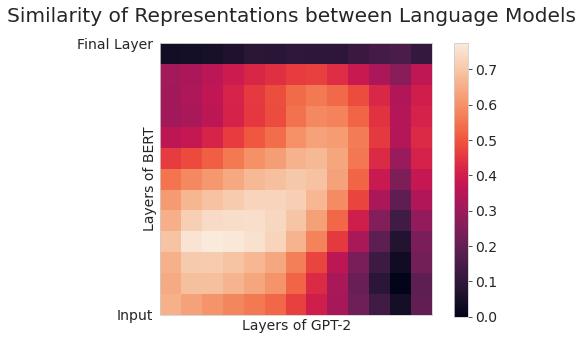

In [ ]:
fig = plt.figure(figsize=(5, 5))
im2 = plt.imshow(rsa(bert_embeddings, gpt_embeddings).cpu().numpy().T, vmin=0)
plt.ylim([-0.5, 12.5])
plt.xticks([])
plt.yticks([-0.5, 12.5], ['Input', 'Final Layer'])
plt.xlabel('Layers of GPT-2', fontdict={'size'   : 14})
plt.ylabel('Layers of BERT', fontdict={'size'   : 14}, labelpad=-80)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.12, 0.04, 0.76])
fig.colorbar(im2, cax=cbar_ax, aspect=50)

plt.suptitle('Similarity of Representations between Language Models', fontsize='x-large')
plt.show()

## Explore context via RSA (not in final paper)

In [ ]:
n=50
 
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert_model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt_model = AutoModel.from_pretrained("gpt2", output_hidden_states=True)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

if device != "cpu":
  bert_model = bert_model.to(device)
  gpt_model = gpt_model.to(device)

context_lengths = list(range(1, 102, 5))
bert_embeddings = [[] for _ in context_lengths]
gpt_embeddings = [[] for _ in context_lengths]
num_data = squad['validation'].num_rows

for index in tqdm.tqdm(range(n)):
  data_index = random.randint(0, num_data - 1)
  sentence = squad['validation'][data_index]['context']

  for index, context in enumerate(context_lengths):
    random_index = min(len(sentence.split(' ')) - 2, 30)
    word_indices = get_word_idx(sentence, sentence.split(' ')[random_index])

    bert_word_embedding = get_word_vector(' '.join(sentence.split(' ')[:random_index + context]), word_indices, bert_tokenizer, bert_model, layers=[11], device=device)
    gpt_word_embedding = get_word_vector(' '.join(sentence.split(' ')[:random_index + context]), word_indices, gpt_tokenizer, gpt_model, layers=[11], device=device)
  
    if device != "cpu":
      bert_word_embedding = bert_word_embedding.detach().cpu()
      gpt_word_embedding = gpt_word_embedding.detach().cpu()

    bert_embeddings[index].append(bert_word_embedding)
    gpt_embeddings[index].append(gpt_word_embedding)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


In [ ]:
# Use a garbage collector to ensure that unused memory is freed

# This is necessary when iteractively using the notebook to free
# up memory both on the CPU and GPU
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Redefine utilities for comparing representations based on new input structure
def process_nested_embeddings(nested_embeddings, layer=8, index=0):
  outputs = []
  all_examples = nested_embeddings[index]
  for example in all_examples:
      outputs.append(example[layer:layer+1, :])
  return torch.stack(outputs, dim=1)

def cosine_similarity(vectors):
  vectors /= torch.norm(vectors, p=2, dim=-1, keepdim=True)
  cosine = torch.einsum('ijk,ilk->ijl', vectors, vectors)
  return cosine

def compare_rsa_contexts(original_embeddings, context_embeddings, layer):
  original = process_nested_embeddings(original_embeddings, layer=layer)
  contexts = [process_nested_embeddings(context_embeddings, index=index, layer=layer) for index in range(len(context_lengths))]
  contexts = torch.concat(contexts, dim=0)
  return rsa(original, contexts).cpu().numpy()[0]

In [ ]:
# Plot RSA similarity as a function of context size
# for layer in range(10):
#   plt.plot(context_lengths[1:], compare_rsa_contexts(bert_embeddings, bert_embeddings, layer)[1:], label=layer)
# plt.legend()
# plt.ylim([0.9, 1.1])

In [ ]:
# for layer in range(10):
#   plt.plot(context_lengths[1:], compare_rsa_contexts(gpt_embeddings, bert_embeddings, layer)[1:], label=layer)
# plt.legend()
# plt.ylim([0, 1.1])

## Analyze attention structure

In [ ]:
# Set the number of input examples to analyze
n=500

In [ ]:
# Reload models to configure output to include attention
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert_model = AutoModel.from_pretrained("bert-base-cased", output_attentions=True)

gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt_model = AutoModel.from_pretrained("gpt2", output_attentions=True)

# Place on device as necessary to improve performance
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if device != "cpu":
  bert_model = bert_model.to(device)
  gpt_model = gpt_model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Utilities to compute mean absolute distance measurements from attention matricues
def get_attention(encoded, token_ids_word, model, layers):
     with torch.no_grad():
         output = model(**encoded)
 
     attention = output.attentions   
     outputs = torch.concat(attention, dim=0)
     sq = attention[0].shape[-1]
     weight = torch.abs(torch.arange(sq).unsqueeze(1) - torch.arange(sq).unsqueeze(0)) / sq

     # Only example attention weights from the latter half of all indices
     # to ensure that there is no bias toward the bidirectional model
     output = (outputs[:, :, int(sq/2):, 1:] * weight[None, None, int(sq/2):, 1:].to(device=outputs.device)).mean((-1, -2)) * sq
     return output
     
def get_attention_vector(sent, idx, tokenizer, model, layers=[], device="cpu"):
     encoded = tokenizer.encode_plus(sent, return_tensors="pt").to(device)
     token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
     return get_attention(encoded, token_ids_word, model, layers)

In [ ]:
# Compute the mean absolute distance over a large set of input examples
bert_weighting_storage = []
gpt_weighting_storage = []
num_data = squad['validation'].num_rows

for index in tqdm.tqdm(range(n)):
  data_index = random.randint(0, num_data - 1)
  sentence = squad['validation'][data_index]['context']

  random_index = min(int(len(sentence.split(' ')) / 2), 50)
  word_indices = get_word_idx(sentence, sentence.split(' ')[random_index])

  bert_weighting = get_attention_vector(' '.join(sentence.split(' ')[:100]), word_indices, bert_tokenizer, bert_model, layers=[11], device=device)
  gpt_weighting = get_attention_vector(' '.join(sentence.split(' ')[:100]), word_indices, gpt_tokenizer, gpt_model, layers=[11], device=device)

  if device != "cpu":
    bert_weighting = bert_weighting.detach().cpu()
    gpt_weighting = gpt_weighting.detach().cpu()

  bert_weighting_storage.append(bert_weighting)
  gpt_weighting_storage.append(gpt_weighting)

100%|██████████| 500/500 [00:09<00:00, 54.45it/s]


In [ ]:
bert_sorted, indices = torch.sort(torch.stack(bert_weighting_storage, dim=0).mean(0), dim=1)

In [ ]:
gpt_sorted, indices = torch.sort(torch.stack(gpt_weighting_storage, dim=0).mean(0), dim=1)

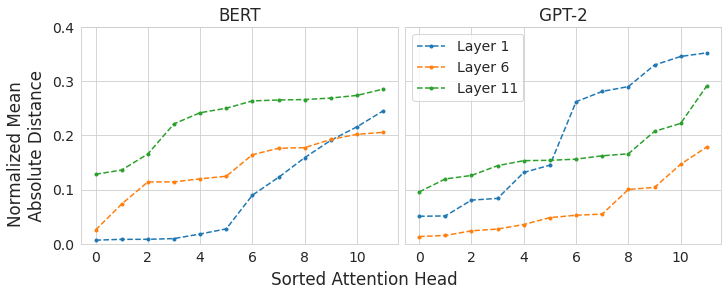

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True,
                        sharex=True, sharey=True)
plt.subplot(1, 2, 1)
for layer in [1, 6, 11]:
  plt.plot(range(12), bert_sorted[layer], '.--', label=f"Layer {layer}")
plt.title("BERT")
plt.ylim([0, 0.4])


plt.subplot(1, 2, 2)
for layer in [1, 6, 11]:
  plt.plot(range(12), gpt_sorted[layer], '.--', label=f"Layer {layer}")
plt.legend()
plt.ylim([0, 0.4])
plt.title("GPT-2")

fig.supxlabel("Sorted Attention Head")
fig.supylabel("Normalized Mean \n Absolute Distance")

plt.show()